## 1. Library Import

In [1]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.style as style
%matplotlib inline

# 폰트 경로 설정
font_path = './H2PORL.TTF'

# 폰트 프로퍼티 설정 및 기본 폰트 변경
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()  
plt.rcParams['font.family'] = 'Malgun Gothic'  # 시스템에 따라 적절한 폰트로 변경
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

# Utilities
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance


## 2. Data Load

#### 2.1. 데이터 로드

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
dt = pd.read_csv('./train.csv')
dt_test = pd.read_csv('./test.csv')
# dt_bus = pd.read_csv('./bus_feature.csv')
# dt_subway = pd.read_csv('./subway_feature.csv')

In [3]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [5]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(2))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,언주로 3,NaN,,직거래,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [6]:
dt.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [7]:
dt.describe()

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,해제사유발생일,단지소개기존clob,k-전체동수,k-전체세대수,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target
count,1.118747e+06,1.118747e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,5.983000e+03,68582.000000,248192.000000,249259.000000,2.492590e+05,249214.000000,249259.000000,249214.000000,249214.000000,249214.000000,327.0,2.491080e+05,249108.000000,249152.000000,249152.000000,1.118822e+06
mean,5.649108e+02,5.978885e+00,7.717475e+01,2.014760e+05,1.580656e+01,8.871968e+00,1.998755e+03,2.021057e+07,541.529979,14.798346,1184.124593,1.614967e+05,94210.104998,120726.487549,477.912838,476.713439,167.528470,70.0,1.895070e+05,1063.678778,126.995228,37.545785,5.799153e+04
std,5.160642e+02,4.668584e+01,2.936423e+01,4.187868e+02,8.721166e+00,5.982584e+00,9.333908e+00,1.060697e+04,751.809853,17.693533,1191.474680,1.839856e+05,101905.956897,129020.276480,759.909400,727.553569,248.928143,0.0,1.729027e+06,1235.437604,0.091045,0.052483,4.642602e+04
min,0.000000e+00,0.000000e+00,1.002000e+01,2.007010e+05,1.000000e+00,-4.000000e+00,1.961000e+03,2.020022e+07,1.000000,1.000000,59.000000,0.000000e+00,2338.000000,0.000000,0.000000,0.000000,0.000000,70.0,0.000000e+00,0.000000,126.798318,37.447843,3.500000e+02
25%,1.760000e+02,0.000000e+00,5.965000e+01,2.011100e+05,8.000000e+00,4.000000e+00,1.992000e+03,2.020082e+07,4.000000,5.000000,403.000000,5.366600e+04,31934.000000,40735.000000,48.000000,95.000000,0.000000,70.0,0.000000e+00,315.000000,126.913157,37.499201,3.050000e+04
50%,4.700000e+02,0.000000e+00,8.188000e+01,2.015070e+05,1.600000e+01,8.000000e+00,2.000000e+03,2.021030e+07,174.000000,10.000000,768.000000,1.016330e+05,60280.000000,78125.000000,225.000000,256.000000,63.000000,70.0,1.710550e+03,683.000000,127.014971,37.544936,4.480000e+04
75%,7.810000e+02,1.000000e+00,8.496000e+01,2.018040e+05,2.300000e+01,1.200000e+01,2.005000e+03,2.022021e+07,725.000000,17.000000,1622.000000,2.039040e+05,117086.000000,159544.000000,576.000000,582.000000,237.000000,70.0,8.414210e+03,1274.000000,127.059590,37.577117,6.980000e+04
max,4.974000e+03,2.837000e+03,4.243200e+02,2.023060e+05,3.100000e+01,6.900000e+01,2.023000e+03,2.023093e+07,2888.000000,124.000000,9510.000000,9.591851e+06,734781.000000,969877.000000,4975.000000,5132.000000,1500.000000,70.0,3.159620e+07,12096.000000,127.179998,37.687725,1.450000e+06


In [8]:
## 결측치 데이터 백분율 계산 후 소수점 두 자리 까지 반올림
round(dt.isnull().sum() / dt.shape[0] * 100.00, 2).sort_values(ascending = False)

k-135㎡초과                  99.97
해제사유발생일                   99.47
k-등록일자                    99.02
단지소개기존clob                93.87
k-홈페이지                    89.88
고용보험관리번호                  81.63
세대전기계약방법                  78.54
k-팩스번호                    78.01
청소비관리형태                   77.87
k-시행사                     77.87
k-건설사(시공사)                77.85
경비비관리형태                   77.85
k-단지분류(아파트,주상복합등등)        77.82
k-전체동수                    77.82
단지승인일                     77.79
k-전화번호                    77.78
k-복도유형                    77.75
건축면적                      77.73
좌표X                       77.73
k-수정일자                    77.73
좌표Y                       77.73
단지신청일                     77.73
주차대수                      77.73
k-85㎡~135㎡이하              77.73
k-전용면적별세대현황(60㎡~85㎡이하)    77.73
k-전용면적별세대현황(60㎡이하)        77.73
k-사용검사일-사용승인일             77.73
k-주거전용면적                  77.73
k-관리비부과면적                 77.72
기타/의무/임대/임의=1/2/3/4       77.72
k-연면적                     77.72
사용허가여부  

## 결측치가 90%에 가까운 값들은 삭제하기
[k-135㎡초과                  99.97
해제사유발생일                   99.47
k-등록일자                    99.02
단지소개기존clob                93.87
k-홈페이지                    89.88]

In [9]:
drop_columns = ['k-135㎡초과', '해제사유발생일', 'k-등록일자', '단지소개기존clob', 'k-홈페이지']

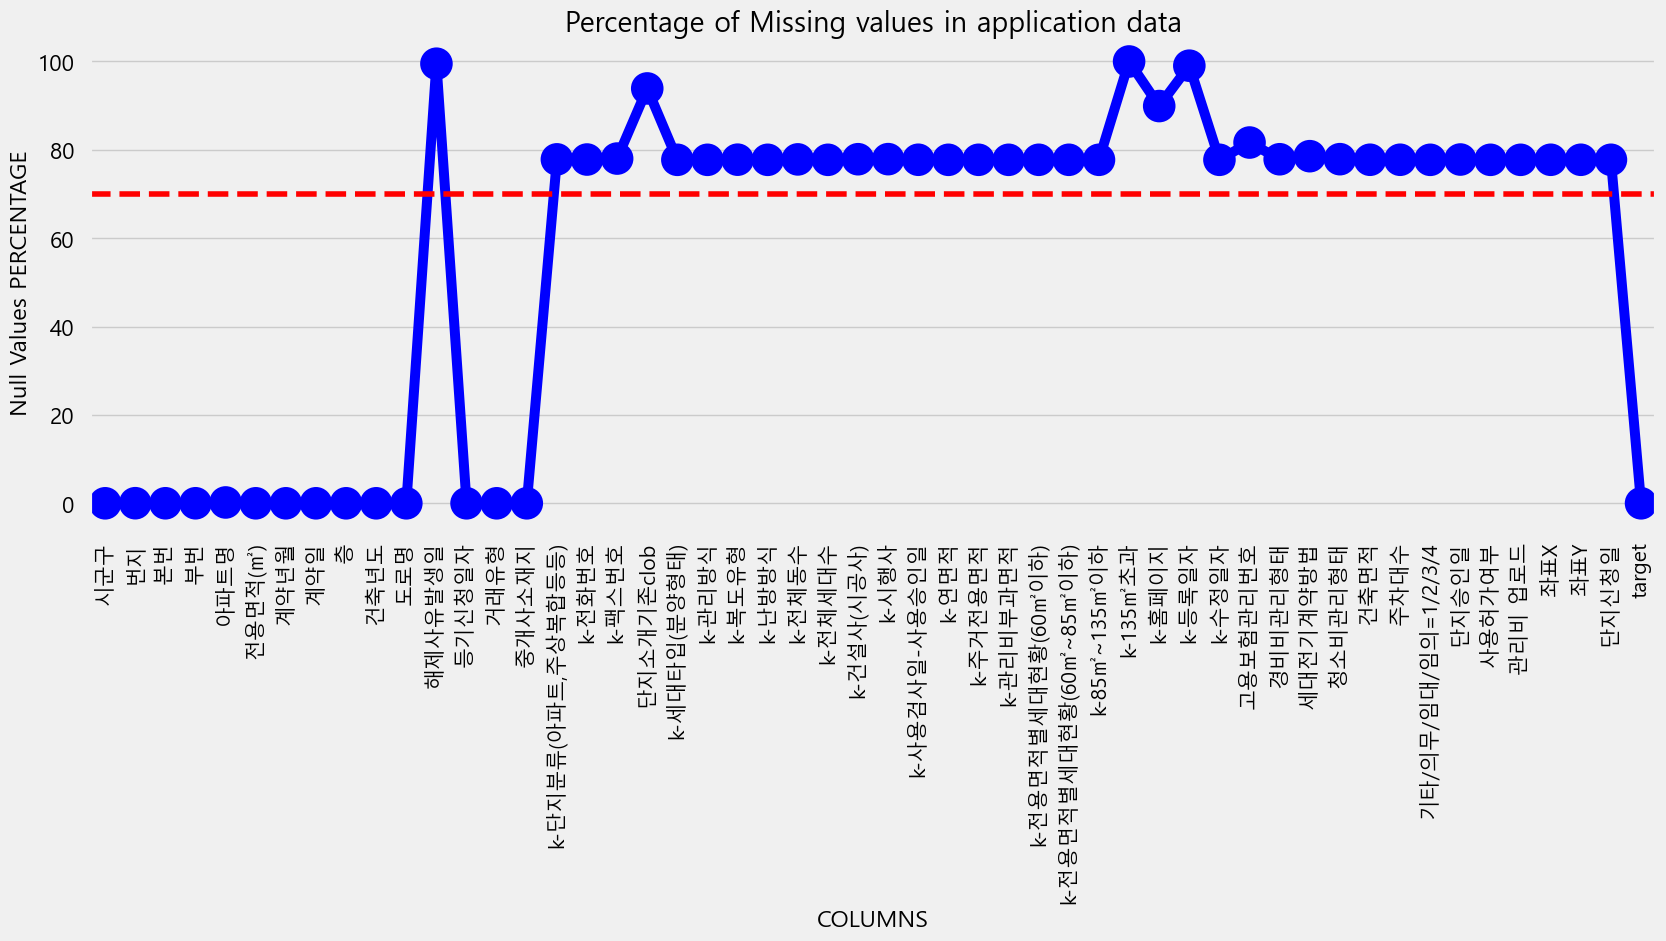

In [10]:
null_applicationDF = pd.DataFrame(dt.isnull().sum() *  100 / dt.shape[0]).reset_index()
null_applicationDF.columns = ['Column Name', 'Null Values Percentage']
fig = plt.figure(figsize = (18,6))
ax = sns.pointplot(x="Column Name", y="Null Values Percentage", data = null_applicationDF, color = 'blue')
plt.xticks(rotation = 90, fontsize = 15)
ax.axhline(70, ls='--', color='red')
plt.title("Percentage of Missing values in application data")
plt.ylabel("Null Values PERCENTAGE")
plt.xlabel("COLUMNS")
plt.show()

In [11]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [12]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [13]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [14]:
concat.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0


In [15]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', 'Missing')

# 결과 확인
display(concat['등기신청일자'].value_counts())

Missing     1111271
20230630        585
20230831        496
20230428        394
20230731        374
20230530        367
20230728        357
20230915        326
20230830        310
20230531        305
20230825        244
20230526        231
20230828        209
20230920        208
20230331        200
20230714        200
20230908        198
20230818        197
20230519        191
20230727        187
20230810        180
20230720        172
20230901        171
20230710        169
20230525        168
20230814        164
20230602        153
20230811        153
20230615        153
20230502        148
20230609        148
20230725        146
20230904        144
20230620        139
20230707        139
20230427        138
20230816        138
20230821        132
20230918        131
20230914        131
20230512        125
20230721        125
20230605        125
20230726        124
20230703        124
20230824        123
20230817        123
20230616        122
20230629        121
20230911        119


## 빈값 처럼 생긴 값이 1111271개 있음 -> 'Missing 처리'

In [16]:
concat['시군구'] = concat['시군구'].apply(lambda x: ' '.join(x.split()[:2]))

concat['시군구'].value_counts()

서울특별시 노원구     115837
서울특별시 송파구      74444
서울특별시 강남구      69656
서울특별시 강서구      67041
서울특별시 강동구      62425
서울특별시 구로구      57983
서울특별시 성북구      57160
서울특별시 양천구      54441
서울특별시 서초구      53553
서울특별시 도봉구      52872
서울특별시 영등포구     48097
서울특별시 동작구      40867
서울특별시 마포구      40810
서울특별시 동대문구     40068
서울특별시 성동구      39831
서울특별시 은평구      38664
서울특별시 중랑구      37303
서울특별시 관악구      36243
서울특별시 서대문구     33272
서울특별시 광진구      22252
서울특별시 강북구      22137
서울특별시 용산구      20682
서울특별시 금천구      19738
서울특별시 중구       13534
서울특별시 종로구       9184
Name: 시군구, dtype: int64

## 소수점 제외

In [17]:
import pandas as pd

# 예시 데이터프레임 생성 (실제 사용 시 여기서부터 시작)
# concat = pd.DataFrame({'전용면적': [84.9600, 59.9900, 84.9000, 59.4000]})

# 전용면적 값을 반올림하여 정수로 변환
concat['전용면적(㎡)'] = concat['전용면적(㎡)'].round().astype(int)

# 결과 확인
concat['전용면적(㎡)'].value_counts()


85     306200
60     188353
59      41950
84      41879
115     35863
50      31787
40      19570
58      14724
83      13044
41       9830
80       9328
51       9094
45       8310
102      7981
71       7804
46       7756
82       7477
79       7467
55       7372
114      7364
72       6380
43       6323
81       6309
44       6247
67       6236
65       6230
73       6142
36       6079
76       5984
69       5621
54       5332
75       5320
49       5305
77       5216
135      5177
56       5093
57       5084
52       4978
74       4786
47       4756
34       4728
53       4549
64       4497
33       4441
42       4389
35       4328
66       4137
32       4013
68       3907
116      3641
100      3621
14       3467
39       3299
106      3223
120      3199
78       3157
108      3138
117      3026
62       3005
122      2935
118      2934
48       2891
134      2873
107      2788
70       2775
101      2741
127      2715
105      2567
113      2546
121      2506
131      2501
61    

In [18]:
def extract_first_word(address):
    # 주소가 NaN이거나 빈 문자열인지 확인
    if pd.isna(address) or not address.strip():
        return '나머지'
    
    # 공백으로 분리하여 첫 단어 추출
    words = address.strip().split()
    if len(words) == 0:  # 분리된 단어가 없는 경우 '나머지' 반환
        return '나머지'
    else:
        first_word = words[0]
        # 첫 단어가 숫자만 있는지 확인
        if first_word.isdigit():
            return '나머지'
        else:
            return first_word

# 새로운 도로명 처리
concat['도로명'] = concat['도로명'].apply(extract_first_word)

# 결과 확인
display(concat['도로명'].value_counts())

마들로           13255
올림픽로          12790
섬밭로           10442
해등로           10307
목동동로           9810
양재대로           9096
고덕로            8681
한글비석로          7797
동일로            7566
목동서로           7440
허준로            7406
독서당로           7375
통일로            7184
노원로            6600
삼성로            6532
솔샘로            6458
송파대로           6367
길음로            5879
선릉로            5276
덕릉로            5243
금하로            4976
경인로            4954
신반포로           4849
중계로            4779
남부순환로          4702
아차산로           4581
상암로            4534
행당로            4412
신내로            4326
신도림로           4290
개포로            4214
금호로            4161
북악산로           4137
양천로            4130
동작대로29길        4034
언주로            3911
천호대로           3861
강서로            3844
사가정로           3822
마포대로           3773
상도로            3738
잠실로            3554
관악로30길         3545
동일로227길        3538
성북로4길          3519
동일로207길        3510
고산자로           3425
이촌로            3418
오패산로           3360
한천로            3347


In [19]:
concat['거래유형'].value_counts()

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [20]:
concat['거래유형'] = concat['거래유형'].replace('-', 'Missing')

# 결과 확인
display(concat['거래유형'].value_counts())

Missing    1086451
중개거래         38123
직거래           3520
Name: 거래유형, dtype: int64

In [21]:
concat['중개사소재지'] = concat['중개사소재지'].apply(lambda x: x.split(',')[0])

In [22]:
concat['중개사소재지'] = concat['중개사소재지'].replace('-', 'Missing')


In [23]:
concat['번지'] = concat['번지'].fillna('Missing')

In [24]:
concat['본번'] = concat['본번'].fillna(0).astype(int)

In [25]:
concat['부번'] = concat['부번'].fillna(0).astype(int)

In [26]:
concat['아파트명'] = concat['아파트명'].fillna('Missing')

In [27]:
# concat 데이터프레임의 모든 열을 반복하며, 
# 각 열의 데이터 타입에 따라 결측치를 적절히 채움
# 'target'과 'is_test' 열은 제외
for column in concat.columns:
    if column not in ['target', 'is_test']: # 'target'과 'is_test' 열 제외
        if concat[column].dtype == 'object':
            concat[column] = concat[column].fillna('Missing')
        elif concat[column].dtype == 'float64':
            concat[column] = concat[column].fillna(0)

# 변경 사항 확인을 위해 다시 정보 출력
concat.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1128094 non-null  object 
 2   본번                      1128094 non-null  int32  
 3   부번                      1128094 non-null  int32  
 4   아파트명                    1128094 non-null  object 
 5   전용면적(㎡)                 1128094 non-null  int32  
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  해제사유발생일                 1128094 non-null  float64
 12  등기신청일자                  1128094 non-null  object 
 13  거래유형                    1128094 non-null  object 
 14  중개사소재

In [28]:
concat.tail(3)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
9269,서울특별시 중랑구,816,816,0,신내우디안1단지,102,202308,27,12,2014,신내역로1길,0.0,Missing,중개거래,서울 중랑구,아파트,024969683,024969685,4.0,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,0.0,Missing,Missing,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.61887,2014-09-01 13:05:03.0,NaN,1
9270,서울특별시 중랑구,816,816,0,신내우디안1단지,85,202309,2,18,2014,신내역로1길,0.0,Missing,중개거래,서울 중랑구,아파트,024969683,024969685,4.0,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,0.0,Missing,Missing,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.61887,2014-09-01 13:05:03.0,NaN,1
9271,서울특별시 중랑구,816,816,0,신내우디안1단지,85,202309,4,13,2014,신내역로1길,0.0,20230905,직거래,Missing,아파트,024969683,024969685,4.0,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,0.0,Missing,Missing,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.61887,2014-09-01 13:05:03.0,NaN,1


In [29]:
# 'k-135㎡초과', '해제사유발생일', 'k-등록일자', '단지소개기존clob', 'k-홈페이지' 열을 삭제
concat = concat.drop(columns=drop_columns)


In [30]:
concat.isnull().sum()

시군구                          0
번지                           0
본번                           0
부번                           0
아파트명                         0
전용면적(㎡)                      0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
등기신청일자                       0
거래유형                         0
중개사소재지                       0
k-단지분류(아파트,주상복합등등)           0
k-전화번호                       0
k-팩스번호                       0
k-세대타입(분양형태)                 0
k-관리방식                       0
k-복도유형                       0
k-난방방식                       0
k-전체동수                       0
k-전체세대수                      0
k-건설사(시공사)                   0
k-시행사                        0
k-사용검사일-사용승인일                0
k-연면적                        0
k-주거전용면적                     0
k-관리비부과면적                    0
k-전용면적별세대현황(60㎡이하)           0
k-전용면적별세대현황(60㎡~85㎡이하)       0
k-85㎡~135㎡이하                 0
k-수정일자  

## 5. Model Training

In [31]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 47) (9272, 47)


In [32]:
dt_train.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구,658-1,658,1,개포6차우성,80,201712,8,3,1987,언주로,Missing,Missing,Missing,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,Missing,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0


In [33]:
dt_test.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구,658-1,658,1,개포6차우성,80,202307,26,5,1987,언주로,Missing,직거래,Missing,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,Missing,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,NaN


### 결측치가 90%이상인 값들은 제외, 수치형 데이터의 경우 0으로 처리, 범주형 데이터의 경우 레이블 인코딩

In [34]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
# 레이블 인코딩은 트리모델에서는 크게 영향을 미치지 않음!
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target']
범주형 변수: ['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [35]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 27/27 [00:07<00:00,  3.80it/s]


In [36]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,0,4732,658,1,328,80,201712,8,3,1987,2430,181,0,0,3,470,427,2,2,1,1,8.0,270.0,241,217,29,22637.0,20204.0,22637.0,20.0,250.0,0.0,214,526,4,1,4,4858.0,262.0,4,725,1,1,127.05721,37.476763,249,124000.0


In [37]:
dt_test.head(1)        # 레이블인코딩이 된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,0,4732,658,1,328,80,202307,26,5,1987,2430,181,2,0,3,470,427,2,2,1,1,8.0,270.0,241,217,29,22637.0,20204.0,22637.0,20.0,250.0,0.0,214,526,4,1,4,4858.0,262.0,4,725,1,1,127.05721,37.476763,249,NaN


In [38]:
dt_train.isnull().sum()

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적(㎡)                   0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
등기신청일자                    0
거래유형                      0
중개사소재지                    0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법            

In [39]:
dt_test.isnull().sum()

시군구                          0
번지                           0
본번                           0
부번                           0
아파트명                         0
전용면적(㎡)                      0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
등기신청일자                       0
거래유형                         0
중개사소재지                       0
k-단지분류(아파트,주상복합등등)           0
k-전화번호                       0
k-팩스번호                       0
k-세대타입(분양형태)                 0
k-관리방식                       0
k-복도유형                       0
k-난방방식                       0
k-전체동수                       0
k-전체세대수                      0
k-건설사(시공사)                   0
k-시행사                        0
k-사용검사일-사용승인일                0
k-연면적                        0
k-주거전용면적                     0
k-관리비부과면적                    0
k-전용면적별세대현황(60㎡이하)           0
k-전용면적별세대현황(60㎡~85㎡이하)       0
k-85㎡~135㎡이하                 0
k-수정일자  

In [40]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [41]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Light GMB 특수문자 에러
import re
# 모든 특수 문자를 밑줄로 대체하기 위해 정규 표현식 사용
def normalize_column_names(df):
    df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    return df

X_train = normalize_column_names(X_train)


# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(684718, 46) (76080, 46) (134259, 46) (684718,) (76080,) (134259,)


In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [44]:
X_train

array([[ 0.89686275,  1.56096705,  0.61473746, ..., -0.5362664 ,
        -0.53626591,  0.5271356 ],
       [-1.01018983, -1.68758848,  0.84113483, ..., -0.5362664 ,
        -0.53626591,  0.5271356 ],
       [-1.59697523, -1.22085143, -0.82685261, ..., -0.5362664 ,
        -0.53626591,  0.5271356 ],
       ...,
       [ 0.01668464, -0.27479239, -0.46693885, ..., -0.5362664 ,
        -0.53626591,  0.5271356 ],
       [-1.30358253, -1.22796465,  1.5551573 , ..., -0.5362664 ,
        -0.53626591,  0.5271356 ],
       [-0.86349347, -0.20530164, -0.43017346, ..., -0.5362664 ,
        -0.53626591,  0.5271356 ]])

In [45]:
from tarfile import XGLTYPE
#학습을 위한 라이브러리 세팅
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

#평가지표
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [46]:
#모델 훈련 함수
def train_models(X_train, y_train):
    models = {
        "LinearRegression": LinearRegression(),
        "XGBRegressor": XGBRegressor(),
        "LGBMRegressor": LGBMRegressor(),
        # "RandomForestRegressor": RandomForestRegressor(), #RandomForest는 과적합되며 모델 학습이 오래걸려서 제외했습니다.
        "CatBoostRegressor": CatBoostRegressor(verbose=0)  # verbose=0으로 설정하여 학습 중 메시지 출력을 최소화
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        models[name] = model

    return models


In [47]:
#train, val 시각화 함수
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# 결과 시각화 함수
def evaluate_regression_models(models, X_train, y_train, X_val, y_val):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}\tTrain RMSE\tVal RMSE\tTrain MAE\tVal MAE\tTrain R²\tVal R²"
    print(header)
    print("-" * len(header))

    for name, model in models.items():
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)

        rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
        rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
        mae_train = mean_absolute_error(y_train, pred_train)
        mae_val = mean_absolute_error(y_val, pred_val)
        r2_train = r2_score(y_train, pred_train)
        r2_val = r2_score(y_val, pred_val)

        print(f"{name.ljust(max_name_length)}\t{rmse_train:.4f}\t\t{rmse_val:.4f}\t\t{mae_train:.4f}\t\t{mae_val:.4f}\t\t{r2_train:.4f}\t\t{r2_val:.4f}")


In [48]:
#모델 test 평가 함수
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# train, val 시각화 함수
def plot_separated_metrics_for_regression_models(models, X_train, y_train, X_val, y_val):
    # 모델별 평가 지표 저장을 위한 리스트
    train_rmse_list = []
    val_rmse_list = []
    train_r2_list = []
    val_r2_list = []
    model_names = []

    # 각 모델별로 평가 지표 계산
    for name, model in models.items():
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        # Check for invalid values
        if np.any(np.isnan(train_pred)) or np.any(np.isnan(val_pred)):
            print(f"Warning: The model {name} predicted NaN values")
            continue
        if not np.all(np.isfinite(train_pred)) or not np.all(np.isfinite(val_pred)):
            print(f"Warning: The model {name} predicted infinite values")
            continue

        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        train_r2 = r2_score(y_train, train_pred)
        val_r2 = r2_score(y_val, val_pred)

        train_rmse_list.append(train_rmse)
        val_rmse_list.append(val_rmse)
        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
        model_names.append(name)

    # RMSE 결과 시각화
    plt.figure(figsize=(20, 10))  # 가로 사이즈 조정

    # 첫 번째 서브플롯 (RMSE)
    plt.subplot(2, 1, 1)  # 두 개의 행, 하나의 열의 첫 번째 서브플롯
    plt.plot(model_names, train_rmse_list, marker='o', label='Training RMSE')
    plt.plot(model_names, val_rmse_list, marker='o', label='Validation RMSE')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE for Different Models')
    plt.legend()

    # 두 번째 서브플롯 (R²)
    plt.subplot(2, 1, 2)  # 두 개의 행, 하나의 열의 두 번째 서브플롯
    plt.plot(model_names, train_r2_list, marker='o', label='Training R²')
    plt.plot(model_names, val_r2_list, marker='o', label='Validation R²')
    plt.ylabel('R²')
    plt.title('Training and Validation R² for Different Models')
    plt.legend()

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()

In [49]:
#모델 훈련
from sklearn.metrics import accuracy_score, f1_score

# 모델 test 평가 함수
def evaluate_regression_models_on_test(models, X_test, y_test):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Test Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}\tTest RMSE\tTest MAE\tTest R2"
    print(header)
    print("-----------------------------------------------------------------------------")

    for name, model in models.items():
        pred_test = model.predict(X_test)

        mse_test = mean_squared_error(y_test, pred_test)
        rmse_test = mse_test ** 0.5
        mae_test = mean_absolute_error(y_test, pred_test)
        r2_test = r2_score(y_test, pred_test)

        print(f"{name.ljust(max_name_length)}\t{rmse_test:.4f}\t\t{mae_test:.4f}\t\t{r2_test:.4f}")


In [50]:
#모델 훈련
models = train_models(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 684718, number of used features: 46
[LightGBM] [Info] Start training from score 58013.826689


In [51]:
#모델 성능평가
evaluate_regression_models(models, X_train, y_train, X_val, y_val)

Model Performance Evaluation:

Model             	Train RMSE	Val RMSE	Train MAE	Val MAE	Train R²	Val R²
------------------------------------------------------------------------
LinearRegression  	31554.7925		31551.0677		20781.8579		20780.8884		0.5364		0.5390
XGBRegressor      	9476.8371		12929.9359		5981.5483		7941.3245		0.9582		0.9226
LGBMRegressor     	12230.7081		13061.8409		7743.8867		8107.2585		0.9303		0.9210
CatBoostRegressor 	8672.8367		11391.3744		5314.3347		6927.7201		0.9650		0.9399


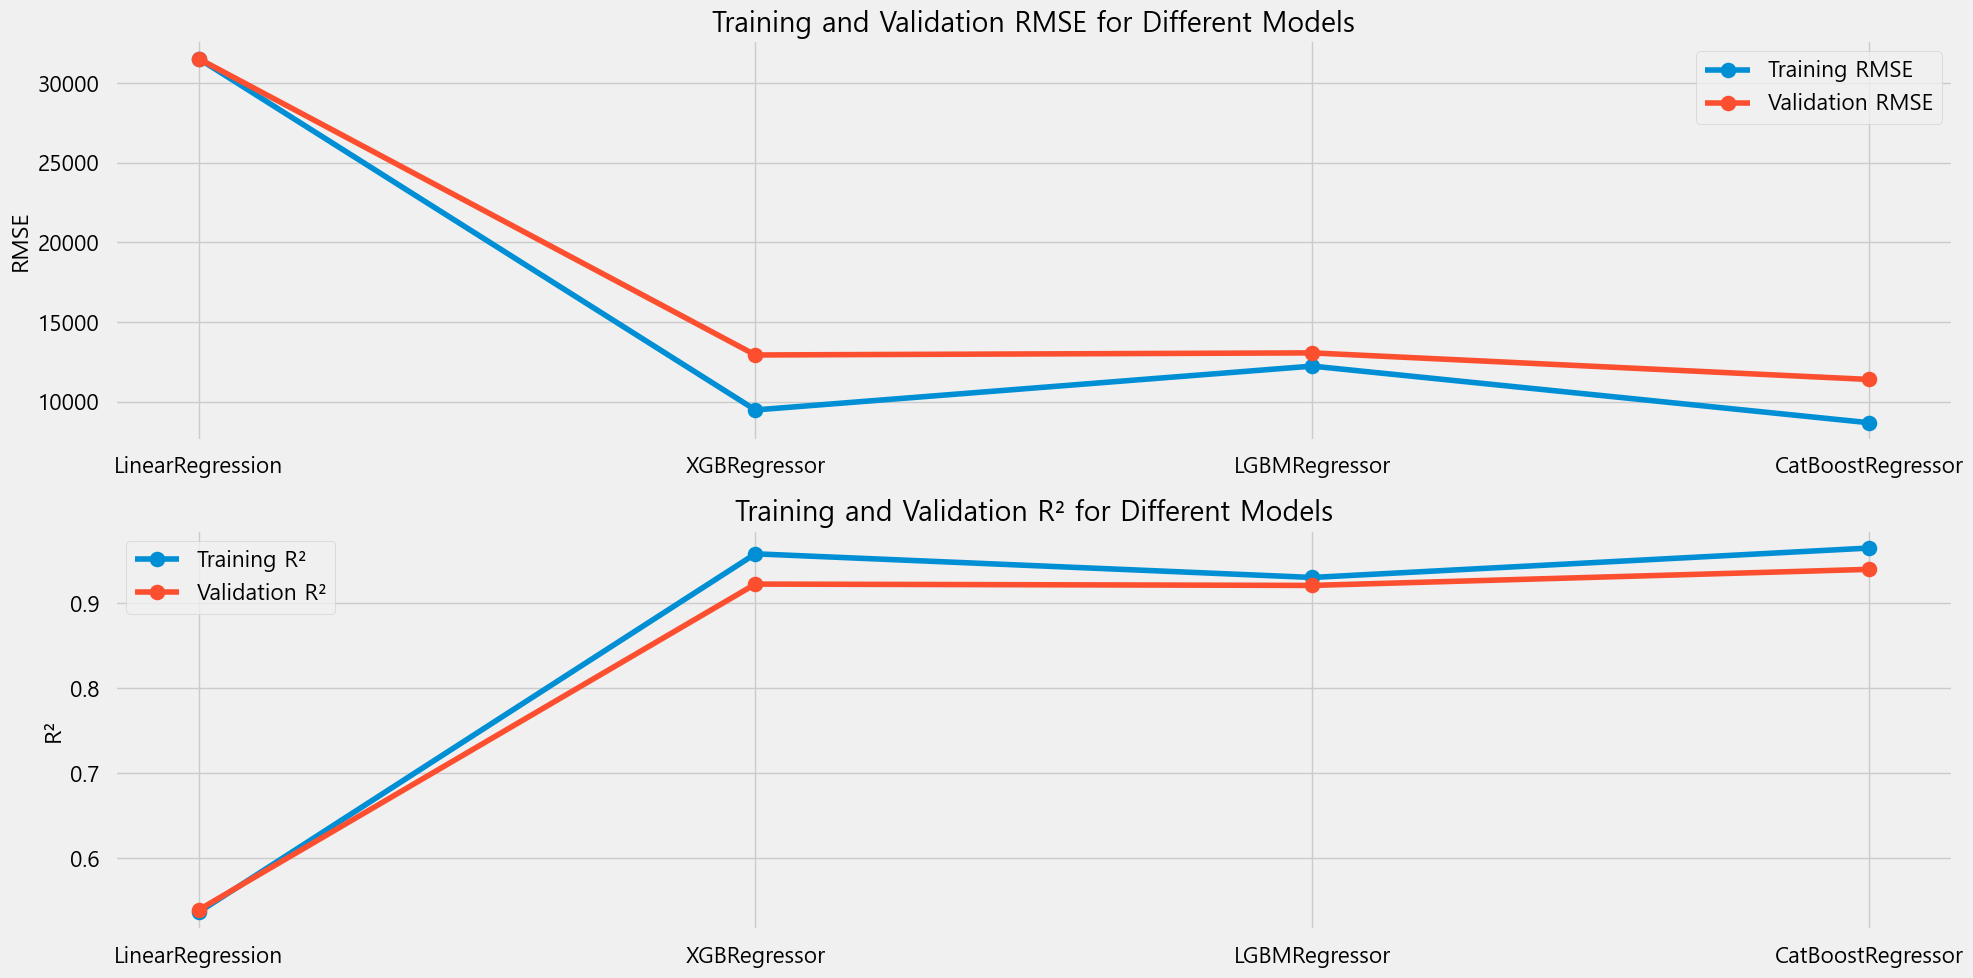

In [52]:
#결과 시각화
plot_separated_metrics_for_regression_models(models, X_train, y_train, X_val, y_val)

# catboost model (Auto ML)

In [53]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# RMSE 스코어러 정의
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# CatBoostRegressor 파라미터 그리드 정의
param_distributions = {
    'depth': [6, 8, 10, 12],  # 깊이를 조금 더 확장하여 세분화
    'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15],  # 학습률을 세분화하고 약간 확장
    'iterations': [1000, 1500, 2000, 2500],  # 반복 횟수를 늘려보기
    'l2_leaf_reg': [1, 3, 5, 7, 9, 12],  # l2_leaf_reg의 범위를 확장
    # 'border_count': [128, 254],  # 기본값 주변으로 탐색
    # 'random_strength': [1, 3, 5, 10],  # 노이즈에 대한 강인함 조절
    # 'bagging_temperature': [0, 1, 10]  # 배깅의 강도 조절
}

# CatBoostRegressor 모델 초기화
reg_catboost = CatBoostRegressor(verbose=0)

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(reg_catboost, param_distributions, n_iter=20, cv=5, verbose=1, scoring=rmse_scorer, random_state=42)

# RandomizedSearchCV를 사용하여 모델 학습
random_search.fit(X_train, y_train)

# 최적 파라미터 출력
print("Best parameters:", random_search.best_params_)

# 최적 파라미터로 학습된 모델
best_model = random_search.best_estimator_
 
# 검증 데이터셋에 대한 예측 및 RMSE 계산
predictions = best_model.predict(X_val)
rmse_val = rmse(y_val, predictions)
print("Validation RMSE with best parameters:", rmse_val)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'learning_rate': 0.125, 'l2_leaf_reg': 1, 'iterations': 2000, 'depth': 12}
Validation RMSE with best parameters: 8062.406275120245


## 비교

### (early stop)

iterations 최대 2,000
Validation RMSE: 8907.660707275254


Best Iteration:  1999

----------------------------------------
### (Auto Ml)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1500, 'depth': 8}

Validation RMSE with best parameters: 8037.796578124483

## 최적의 파라미터로 모델 재학습!

In [54]:
# X_train과 X_val을 합쳐서 전체 훈련 데이터셋을 생성합니다.
X_full_train = np.concatenate((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))

# RandomizedSearchCV에서 찾은 최적의 파라미터를 사용하여 모델 초기화
optimal_params = random_search.best_params_
optimal_model = CatBoostRegressor(**optimal_params, verbose=0)

In [55]:
# 전체 훈련 데이터셋으로 모델을 학습
optimal_model.fit(X_full_train, y_full_train)

In [56]:
# dt_test 데이터에서 독립변수들만 추출 (여기서는 'target' 컬럼이 없다고 가정합니다)
X_test = dt_test.copy()

# 특수 문자가 포함된 컬럼명을 '_'로 변경 (모델 학습 시와 동일하게 처리)
X_test.columns = [re.sub(r'[^\w]', '_', col) for col in X_test.columns]


In [57]:
# X_test에서 'target' 컬럼 제거
X_test = X_test.drop(columns=['target'])

# 이제 X_test의 피처 수가 X_train과 일치하므로 스케일링을 진행할 수 있습니다.
X_test_scaled = scaler.transform(X_test)


In [58]:
# sample.submission.csv 파일 로드
sample_submission = pd.read_csv('./sample_submission.csv')

# 파일 형식 확인
print(sample_submission.head())


   target
0  179048
1   84820
2  248141
3  180991
4  295430


In [59]:
# CatBoost 모델을 사용하여 테스트 데이터셋에 대한 예측 수행
predictions = optimal_model.predict(X_test_scaled)

# 예측 결과를 sample_submission DataFrame에 할당
sample_submission['target'] = predictions

# 결과를 정수형으로 변환할 필요가 있다면 다음 라인을 사용 (회귀 문제인 경우 필요 없을 수 있음)
sample_submission['target'] = sample_submission['target'].astype(int)

# 결과를 CSV 파일로 저장
submission_file_path = './catboost_automl_submission_0326.csv'
sample_submission.to_csv(submission_file_path, index=False)
print(f'Saved {submission_file_path}')


Saved ./catboost_automl_submission_0326.csv
